In [25]:
import os
import pandas as pd
import numpy as np
import xarray as xr

from scipy.ndimage import gaussian_filter1d

from mpas_tools.mesh.interpolation import interp_bilin

from scripts import isinside

import matplotlib.pyplot as plt
%matplotlib inline

# Create the mesh

In [64]:
length = 200e3  # in meter
width = 100e3  # in meter
grid_resolution = 1000.  # in meter
node_x = int(length/grid_resolution+1)
node_y = int(width/grid_resolution+1)
node_x, node_y

(201, 101)

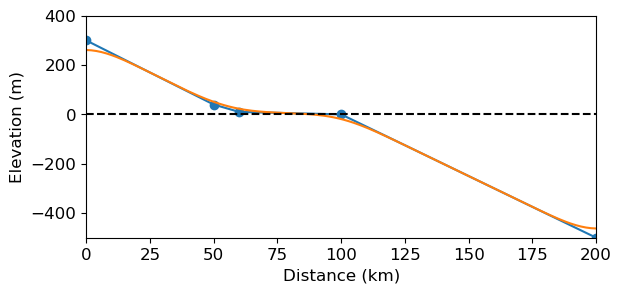

In [69]:
# Build initial surface profile based on given points
xdata = np.array([0,50,60,100,200])*1000
elev = np.array([300,40,10,0,-500])

f = interp1d(xdata, elev)
xnew = np.linspace(0, length, node_x)
ynew = np.linspace(0, width, node_y)
elev_new = f(xnew)
elev_new_gs = gaussian_filter1d(elev_new,sigma=10) 

# Visualize the profile
fig = plt.figure(figsize = (6,3))
plt.rc("font", size=12)
ax = fig.add_axes([0.11, 0.18, 0.85, 0.74])
ax.scatter(xdata/1e3, elev) 
ax.plot(xnew/1e3,elev_new)
ax.plot(xnew/1e3, elev_new_gs)
ax.axhline(y=0., color='k', linestyle='--')
ax.set_xlim([0,200])
ax.set_ylim([-500,400]) 
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Elevation (m)')
plt.show()

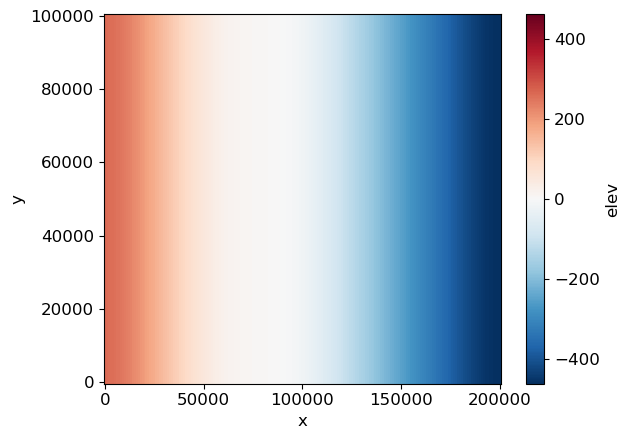

In [70]:
elev = np.broadcast_to(elev_new_gs, (node_x, node_x))[:node_y,:]

ds = xr.Dataset({
    'elev': xr.DataArray(
                data   = elev,
                dims   = ['y','x'],
                coords = {'x': xnew,'y': ynew},
                ),
        }
    )
ds.elev.plot()

Build the triangular grid and interpolate the variables on the unstructured mesh:

In [73]:
pts2D, cells = isinside.delaunayMesh([xnew[0],ynew[0],xnew[-1],ynew[-1]], 500)
hData = interp_bilin(xnew, ynew, ds.elev.values, pts2D[:,0], pts2D[:,1])

Save the goSPL mesh:

In [74]:
# name of the folder where the inputs would be stored
mesh_path = 'inputs'
if not os.path.exists(mesh_path):
    os.makedirs(mesh_path)

coords = np.zeros((len(pts2D),3))
coords[:,:2] = pts2D

# Elevation mesh
elevfname = mesh_path+"/mesh2"
np.savez_compressed(elevfname, v=coords, c=cells, z=hData)

Make a sea-level curve

In [34]:
def buildCurve(timeExt = None, timeStep = None, seaExt = None,
                   ampExt = None, periodExt = None):
        """
        Curve created which interpolate linearly the averaged values of sea-level
        trends over the specified time period.

        Parameters
        ----------
        variable: timeExt
            Extent of the simulation time: start/end time (in years)

        variable: timeStep
            Discretisation step for time range (in years).

        variable: seaExt
            Sea level value for starting and ending times (in metres)

        variable: ampExt
            Amplitude of the sea level wave for starting and ending times (in metres)

        variable: periodExt
            Period of the sea level wave for starting and ending times (in years)
        """

        dt = float(timeStep)
        so = float(seaExt[0])
        sm = float(seaExt[1])
        to = float(timeExt[0])
        tm = float(timeExt[1])+dt
        Ao = float(ampExt[0])
        Am = float(ampExt[1])
        Po = float(periodExt[0])
        Pm = float(periodExt[1])

        time = np.arange(to,tm,dt,dtype=float)

        # Sea-level
        a0 = (sm - so)/(tm - to)
        b0 = so - a0 * to
        sl = a0 * time + b0
        # Amplitude
        a1 = (Am - Ao)/(tm - to)
        b1 = Ao - a1 * to
        A = a1 * time + b1
        # Period
        a2 = (Pm - Po)/(tm - to)
        b2 = Po - a2 * to
        P = a2 * time + b2

        for t in range(len(time)):
            sl[t] += A[t] * np.cos(2.* np.pi * (time[t] - to) / P[t])

        return time, sl

timeExt = [0.,5.e5]
timeStep = 5.e3
seaExt = [0.,-40]
ampExt = [1,20]
periodExt = [2.e4,1.e5]
time, sl = buildCurve(timeExt,timeStep,seaExt,ampExt,periodExt)

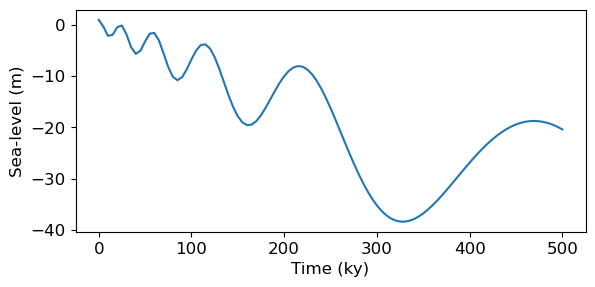

In [35]:
# Visualize the profile
fig = plt.figure(figsize = (6,3))
plt.rc("font", size=12)
ax = fig.add_axes([0.11, 0.18, 0.85, 0.74])
ax.plot(time/1000,sl)
ax.set_xlabel('Time (ky)')
ax.set_ylabel('Sea-level (m)')
plt.show()

Save it as file for goSPL simulation:

In [36]:
df = pd.DataFrame({'X':np.around(time, decimals=0),'Y':np.around(sl, decimals=3)})
df.to_csv('inputs/sealevel.csv',columns=['X', 'Y'], sep=' ', index=False ,header=0)